# Will the customer subscribe to a term deposit?

![](images/kurt.jpeg)

### Overview

In this investigation, we explore a dataset from a Portuguese banking institution, which is a collection of the results of multiple marketing campaigns. Our goal is to understand what type of classifier is best able to predict whether a customer will subscribe to a term deposit account. We consider the following classifiers:  <b>k-nearest neighbors, logistic regressor, decision trees, and support vector machines </b>. As a result of the analysis, we provide to our customer -- the bank -- an optimal classifier to use to predict whether a prospective depositer will subscribe to the product (a term deposit).

### Data Understanding

We visualize the data in tablular form to get familiar it, as follows: 

* View the data and understand the meaning of the various features (columns) of the data
* Identify incomplete data and decide upon a reasonable apporoach to handling such data.
* Get a feel for how closely correlated the features are to each other. This will help us understand if there are redundant features which do not add significantly to data understanding. 


### Data Preparation

In [24]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import os
import random
import math

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression 
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import time

In [25]:
# Load the data
bankDf = pd.read_csv("data/bank-additional.csv")
bankDf

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
4115,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,no
4116,27,student,single,high.school,no,no,no,cellular,may,mon,...,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
4117,58,admin.,married,high.school,no,no,no,cellular,aug,fri,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no


In [26]:
bankDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

### Cleanup 1:
Drop columns that are not useful characterestics for modeling - 'month' and 'day_of_week' of last contact. In particular drop 'duration' (duration of last contact) since that is essentially the final contact where the customer accepts or rejects opening an account - it is essentially the same as the final outcome.

In [27]:
# Drop 'month', 'day_of_week', 'duration' as explained above
bankDf = bankDf.drop(['month', 'day_of_week', 'duration'], axis = 1)

In [28]:
# Also drop 'pdays' - the number of days since last contact - since most customers were not contacted (sparse data)

In [29]:
bankDf = bankDf.drop(['pdays'], axis = 1)

In [30]:
# Hindsight: drop the only row with education = 'illiterate' since it gives a runtime error
bankDf.value_counts('education')

education
university.degree      1264
high.school             921
basic.9y                574
professional.course     535
basic.4y                429
basic.6y                228
unknown                 167
illiterate                1
Name: count, dtype: int64

In [31]:
bankDf = bankDf.drop(bankDf[bankDf.education == 'illiterate'].index)

In [32]:
# rename target column to 'subscribed'
bankDf.rename(columns = {'y':'subscribed'}, inplace = True)

In [33]:
bankDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4118 entries, 0 to 4118
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4118 non-null   int64  
 1   job             4118 non-null   object 
 2   marital         4118 non-null   object 
 3   education       4118 non-null   object 
 4   default         4118 non-null   object 
 5   housing         4118 non-null   object 
 6   loan            4118 non-null   object 
 7   contact         4118 non-null   object 
 8   campaign        4118 non-null   int64  
 9   previous        4118 non-null   int64  
 10  poutcome        4118 non-null   object 
 11  emp.var.rate    4118 non-null   float64
 12  cons.price.idx  4118 non-null   float64
 13  cons.conf.idx   4118 non-null   float64
 14  euribor3m       4118 non-null   float64
 15  nr.employed     4118 non-null   float64
 16  subscribed      4118 non-null   object 
dtypes: float64(5), int64(3), object(9)
mem

In [34]:
# convert categorical data to numeric using labelEncoder
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
num_cols = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed']

### Correlations in the data

In [35]:
# Dataframe of numeric features only
num_df = bankDf[num_cols]

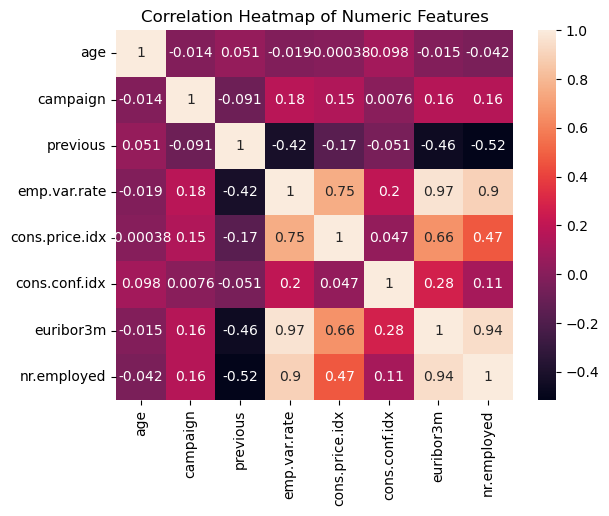

In [36]:
# Correlation heatmap between numeric features
hMap = sns.heatmap(num_df.corr(), annot = True)
hMap.axes.set_title('Correlation Heatmap of Numeric Features')
hMap.get_figure().savefig('images/CorrHeatmap.png')

#### Observation
We observe that some numeric variable pairs like <b>(nr.employed, euribor3m)</b> and <b>(emp.var.rate, euribor3m)</b> have a <b>very strong positive correlation</b>. This is rather surprising and indicates a <b>possible bias in the data</b>, since the  Euro Interbank Offered Rate (euribor) should a-priori have no connection with number of employees (nr.employed) or employment variation rate (emp.var.rate)

In [37]:
# Data: indepndent and dependent variables
X = bankDf.drop(['subscribed'], axis = 1)

# target
labelEnc = LabelEncoder()
y = labelEnc.fit_transform(bankDf['subscribed'])

### Preprocessing the data
We use an <b> OrdinalEncoder </b> to encode categorical data. This is reasonable in this context because we are interested in a class prediction (yes/no), given a new data point. For this classification purpose, there is no implied hierarchy or importance attached to any specific numeric value that we convert a categoric value to. We just need to map each categorical feature to <b><i>some</i></b> numeric value so that the numeric algorithms can process the data.

In [38]:
# Preprocessing pipeline for numerical and categorical features
preprocPipe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OrdinalEncoder(), cat_cols)
    ])

In [39]:
# Data, split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 32)

### Building a model for each classifier

In [40]:
# Model pipelines
logRegPipe = make_pipeline(preprocPipe, LogisticRegression(max_iter=10000))
decTreePipe = make_pipeline(preprocPipe, DecisionTreeClassifier())
knnPipe = make_pipeline(preprocPipe, KNeighborsClassifier())
svmPipe = make_pipeline(preprocPipe, SVC())

pipelines = [logRegPipe, decTreePipe, knnPipe, svmPipe]

### Model evaluation

In [41]:
# Evaluating the models
model_performance = []

for pipe in pipelines:
        #Start a timer
        start_time = time.time()
        
        # fit the data
        pipe.fit(X_train, y_train)
        
        #End the timer, get elapsed time
        end_time = time.time()
        fit_time = end_time - start_time

        # Make a prediction, measure the accuracy
        y_pred = pipe.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        
        modelName = type(pipe._final_estimator).__name__

        model_performance.append({
            'Model': modelName,
            'Score': score,
            'Time': fit_time
            })
        

In [42]:

# Dataframe out of the results
performDf = pd.DataFrame(model_performance)

In [43]:
performDf

,Model,Score,Time
0,LogisticRegression,0.902104,0.039892
1,DecisionTreeClassifier,0.837379,0.027925
2,KNeighborsClassifier,0.882686,0.012967
3,SVC,0.898867,0.243350


In [44]:
pFig1 = px.bar(performDf, x = 'Model', y = 'Score')
pFig1.update_layout(
            title={
            'text' : 'Model Accuracy',
            'x':0.5,
            'xanchor': 'center'
        })
pFig1.show()

In [45]:
pFig2 = px.bar(performDf, x = 'Model', y = 'Time',
                labels = {
                     "Model": "Model",
                     "Time": "Time (seconds)",
                 })

pFig2.update_layout(
            title={
            'text' : 'Model Computation Time',
            'x':0.5,
            'xanchor': 'center'
        })
pFig2.show()

### Evaluation

#### Model Accuracy
While all models had a reasonably high accuracy (> 85%), <b>Logictic Regression</b> and <b>Support Vector Machines</b> stood out with a <b>90%</b> accuracy. <br/>

#### Computational performance

The <b> K Nearest Neighbors Classifier </b> stood out as easily being the fastest computationally, while <b> Support Vector Machines</b> was the poorest performer by a significant margin. <b>Logistic Regression </b> had moderate performance characterestics.


### Recommendations

Based on the results of our Machine Learning models, considering both Model Accuracy with Computational Performance, we can recommend that <b>Logistic Regression </b> is the best model to use to predict customer subscription to the bank's term deposit product.

### Next Steps

It will be useful to dive deeper into the very strong correlation between the feature pairs <b>(nr.employed, euribor3m)</b> and <b>(emp.var.rate, euribor3m)</b>. As noted earlier this could indicate a <b>possible bias in the data</b>, since the  Euro Interbank Offered Rate (euribor) should a-priori have no connection with number of employees (nr.employed) or employment variation rate (emp.var.rate)